In [ ]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


immigration_data = pd.read_csv('./datasets/EU_Immigrants.csv')

: 

In [3]:
immigration_data.head(), immigration_data.info(), immigration_data.describe()

# Dropping rows with all null values and resetting the index
cleaned_data = immigration_data.dropna(how='all').reset_index(drop=True)

# Check the cleaned data to ensure no full rows of null values are present
cleaned_data.info(), cleaned_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 23 columns):
 #   Column                                                                             Non-Null Count  Dtype  
---  ------                                                                             --------------  -----  
 0   EU COUNTRIES                                                                       31 non-null     object 
 1   TOTAL IMMIGRANTS(IN THOUSANDS)                                                     31 non-null     float64
 2   IMMIGRANTS WITH NATIONALITY(THOUSANDS)                                             31 non-null     float64
 3   IMMIGRANTS WITH NATIONALITY(%age)                                                  31 non-null     float64
 4   NON-NATIONAL IMMIGRANTS (THOUSANDS)                                                31 non-null     float64
 5   NON-NATIONAL IMMIGRANTS (%age)                                                     31 non-null     float64
 

(None,
   EU COUNTRIES  TOTAL IMMIGRANTS(IN THOUSANDS)  \
 0      Austria                           118.5   
 1      Belgium                           139.7   
 2     Bulgaria                            39.5   
 3      Croatia                            35.9   
 4       Cyprus                            24.0   
 
    IMMIGRANTS WITH NATIONALITY(THOUSANDS)  IMMIGRANTS WITH NATIONALITY(%age)  \
 0                                     9.6                                8.1   
 1                                    17.4                               12.4   
 2                                    22.1                               56.0   
 3                                    10.6                               29.6   
 4                                     4.0                               16.6   
 
    NON-NATIONAL IMMIGRANTS (THOUSANDS)  NON-NATIONAL IMMIGRANTS (%age)  \
 0                                108.8                            91.8   
 1                                121.7        

In [4]:
from sklearn.preprocessing import StandardScaler

# Selecting numerical columns (excluding country names)
features = cleaned_data.columns[1:]

# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(cleaned_data[features])

scaled_data.shape

(31, 22)

In [ ]:
import numpy as np
from multiprocessing import Pool
from functools import partial

def compute_covariance_row(data, feature_index):
    """Compute the covariance matrix row for the specified feature index."""
    n_samples = data.shape[0]
    feature_row = data[:, feature_index]
    covariances = np.array([np.dot(feature_row, data[:, i]) / n_samples for i in range(data.shape[1])])
    return covariances

def custom_pca(data, n_components=2):
    # Center the data
    feature_means = np.mean(data, axis=0)
    centered_data = data - feature_means

    # Calculate the covariance matrix in parallel
    with Pool() as pool:
        covariance_matrix = np.array(pool.map(partial(compute_covariance_row, centered_data), range(centered_data.shape[1])))

    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

    # Sort the eigenvectors by descending eigenvalues
    idx = eigenvalues.argsort()[::-1]
    sorted_eigenvectors = eigenvectors[:, idx]

    # Select the top n_components eigenvectors (principal components)
    principal_components = sorted_eigenvectors[:, :n_components]

    # Project the data onto these principal components
    transformed_data = np.dot(centered_data, principal_components)

    return transformed_data, eigenvalues[idx[:n_components]]

# Test the custom PCA
data = np.random.rand(100, 10)  # Random dataset for testing
pca_results, explained_variances = custom_pca(data, n_components=2)


Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/czaacza/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/czaacza/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/czaacza/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/czaacza/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'compute_covariance_row' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/czaacza/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/czaacza/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/

In [7]:
from sklearn.decomposition import PCA
import numpy as np

# Applying PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization
principal_components = pca.fit_transform(scaled_data)

# Explained variance ratio by the first two principal components
explained_variance = pca.explained_variance_ratio_

explained_variance, principal_components.shape

(array([0.32408273, 0.24173771]), (31, 2))

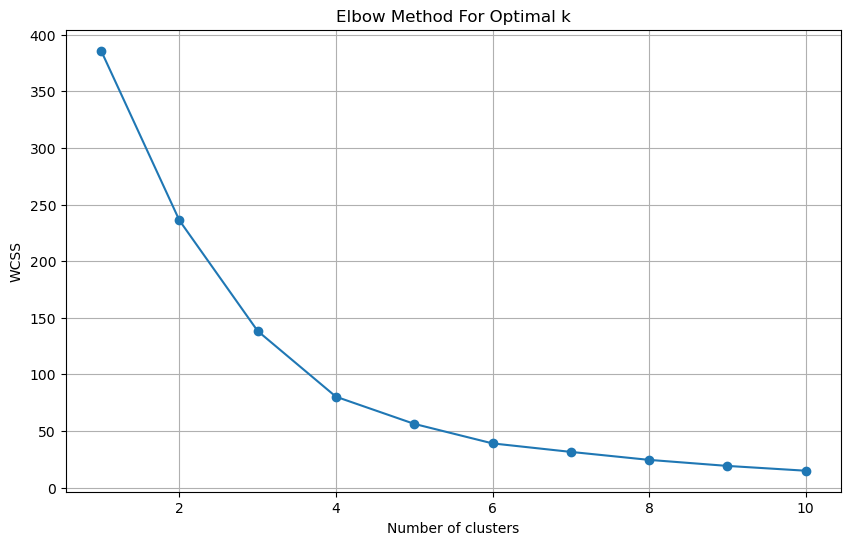

In [18]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Determining the optimal number of clusters using the Elbow method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):  # Testing 1 to 10 clusters
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(principal_components)
    wcss.append(kmeans.inertia_)

# Plotting the Elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')  # Within-cluster sum of squares
plt.grid(True)
plt.show()


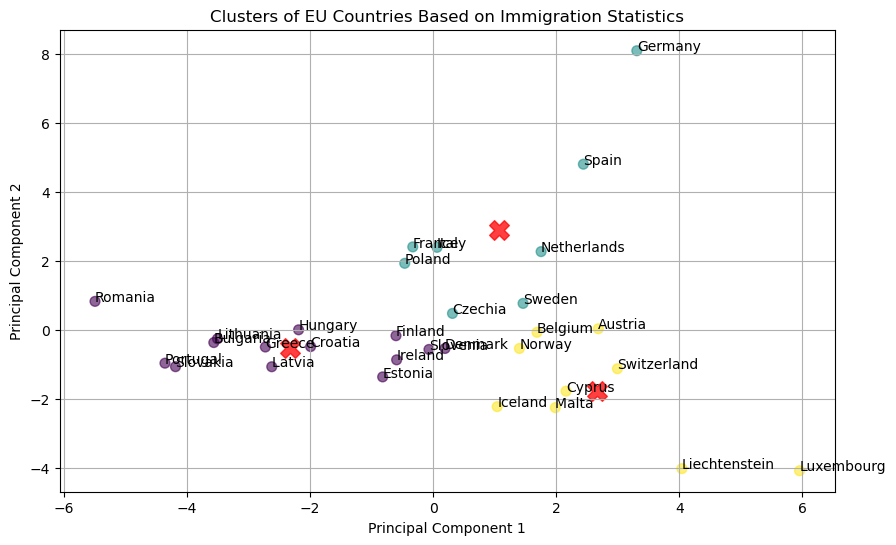

In [19]:
# Applying K-means clustering with the optimal number of clusters found
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(principal_components)

# Plotting the clusters
plt.figure(figsize=(10, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.6)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')  # Mark cluster centers

for i, txt in enumerate(cleaned_data['EU COUNTRIES']):
    plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]))

plt.title('Clusters of EU Countries Based on Immigration Statistics 2022')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()
